# Time series analysis on AWS
*Chapter 3 - Creating a project and ingesting your data*

## Initializations
---

In [1]:
!pip install --quiet tqdm kaggle

### Imports

In [1]:
import numpy as np
import os
import pandas as pd
import warnings
import zipfile

from tqdm import tqdm

### Parameters

In [2]:
RAW_DATA = os.path.join('..', 'Data', 'raw')
DATA = os.path.join('..', 'Data')
warnings.filterwarnings("ignore")
os.makedirs(RAW_DATA, exist_ok=True)

### Helper functions

In [3]:
from IPython.display import display_html

def display_multiple_dataframe(*args, max_rows=None, max_cols=None):
    html_str = ''
    for df in args:
        html_str += df.to_html(max_cols=max_cols, max_rows=max_rows)
        
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)

### Downloading datasets

To download the London household energy consumption with weather data from Kaggle, you will need a Kaggle API token. To do so, you will need to have an account on Kaggle and create a token that you install on your machine. You can follow [**this link**](https://www.kaggle.com/docs/api) to get started with the Kaggle API. Once generated, make sure your Kaggle token is stored in the `~/.kaggle/kaggle.json` file, or the next cells will issue an error. To get a Kaggle token, go to kaggle.com and create an account. Then navigate to **My account** and scroll down to the API section. There, click the **Create new API token** button:

<img src="../Assets/kaggle_api.png" />

In [4]:
FILE_NAME    = 'smart-meters-in-london.zip'
ARCHIVE_PATH = os.path.join(RAW_DATA, FILE_NAME)
FILE_PATH    = os.path.join(DATA, 'energy-london', 'smart-meters-in-london.zip')
FILE_DIR     = os.path.dirname(FILE_PATH)

# Checks if the data were already downloaded:
if os.path.exists(os.path.join(DATA, 'energy-london', 'acorn_details.csv')):
    print("File found, skipping download")
    
else:
    # Downloading and unzipping datasets from Kaggle:
    print("Downloading dataset (2.26G), can take a few minutes depending on your connection")
    os.makedirs(os.path.join(DATA, 'energy-london'), exist_ok=True)
    !kaggle datasets download -d jeanmidev/smart-meters-in-london -p $RAW_DATA
    
    print('Unzipping files...')
    zip_ref = zipfile.ZipFile(ARCHIVE_PATH, 'r')
    zip_ref.extractall(FILE_DIR + '/')
    zip_ref.close()
    
    !rm $DATA/energy-london/*zip
    !rm $DATA/energy-london/*gz
    !mv $DATA/energy-london/halfhourly_dataset/halfhourly_dataset/* $DATA/energy-london/halfhourly_dataset
    !rm -Rf $DATA/energy-london/halfhourly_dataset/halfhourly_dataset
    !mv $DATA/energy-london/daily_dataset/daily_dataset/* $DATA/energy-london/daily_dataset
    !rm -Rf $DATA/energy-london/daily_dataset/daily_dataset

File found, skipping download


## Dataset visualization
---

We want to filter out households that are are subject to the dToU tariff and keep only the ones with a known ACORN (i.e. not in the ACORN-U group): this will allow us to better model future analysis by adding the Acorn detail informations (which by definitions, won't be available for the ACORN-U group).

In [5]:
household_filename = os.path.join(DATA, 'energy-london', 'informations_households.csv')
household_df = pd.read_csv(household_filename)
household_df = household_df[(household_df['stdorToU'] == 'Std') & (household_df['Acorn'] != 'ACORN-U')]
household_ids = household_df['LCLid'].tolist()
print(household_df.shape)
household_df.head()

(4404, 5)


,LCLid,stdorToU,Acorn,Acorn_grouped,file
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0
5,MAC003579,Std,ACORN-A,Affluent,block_0
6,MAC003566,Std,ACORN-A,Affluent,block_0


In [6]:
bad_household_ids = [
    'MAC002136', 'MAC002594', 'MAC000636', 'MAC001309', 'MAC001269', 'MAC000037', 'MAC002072', 'MAC000197', 
    'MAC001644', 'MAC005040', 'MAC000404', 'MAC004982', 'MAC001959', 'MAC002564', 'MAC001829', 'MAC000504', 
    'MAC001522', 'MAC001456', 'MAC004732', 'MAC000915', 'MAC005232', 'MAC003993', 'MAC000530', 'MAC000235', 
    'MAC001549', 'MAC000220', 'MAC005344', 'MAC000120', 'MAC000172', 'MAC002050', 'MAC000287', 'MAC005191', 
    'MAC000964'
]
household_df = household_df[~household_df['LCLid'].isin(bad_household_ids)]

#### Associating households with they energy consumption data
Each household (with an ID starting by `MACxxxxx` in the table above) has its consumption data stored in a block file name `block_xx`. This file is also available from the `informations_household.csv` file extracted above. We have the association between `household_id` and `block_file`: we can open each of them and keep the consumption for the households of interest. All these data will be concatenated into an `energy_df` dataframe. For the remaining of this analysis, we are going to extract 1 year of data between July 1st, 2012 and June 30th, 2013 and we are going to keep only the households with almost 100% complete data for this period:

In [7]:
start            = pd.to_datetime('2012-07-01 00:00:00')
end              = pd.to_datetime('2013-06-30 23:59:00')
threshold        = 0.95
min_data_points  = ((end - start).days + 1)*24*2 * threshold

In [8]:
consumption_file = os.path.join(DATA, 'energy-london', 'half_hourly_consumption-v2.csv')
if os.path.exists(consumption_file):
    print('Half-hourly consumption file already exists, loading from disk...')
    energy_df = pd.read_csv(consumption_file)
    energy_df['timestamp'] = pd.to_datetime(energy_df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
    print('Done.')
    
else:
    print('Half-hourly consumption file not found. We need to generate it.')
    
    # We know have the block number we can use to open the right file:
    energy_df = pd.DataFrame()
    target_block_files = household_df['file'].unique().tolist()
    print('- {} block files to process: '.format(len(target_block_files)), end='')
    df_list = []
    for block_file in tqdm(target_block_files):
        # Reads the current block file:
        current_filename = os.path.join(DATA, 'energy-london', 'halfhourly_dataset', '{}.csv'.format(block_file))
        df = pd.read_csv(current_filename)
        
        # Set readable column names and adjust data types:
        df.columns = ['household_id', 'timestamp', 'energy']
        df = df.replace(to_replace='Null', value=0.0)
        df['energy'] = df['energy'].astype(np.float64)
        df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
        df = df[(df['timestamp'] >= start) & (df['timestamp'] <= end)]
        
        # We filter on the households sampled earlier:
        df_list.append(df[df['household_id'].isin(household_ids)].reset_index(drop=True))
        del df
    
    # Concatenate with the main dataframe:
    energy_df = pd.concat(df_list, axis='index', ignore_index=True)
    
    datapoints = energy_df.groupby(by='household_id').count()
    datapoints = datapoints[datapoints['timestamp'] < min_data_points]
    hhid_to_remove = datapoints.index.tolist()
    energy_df = energy_df[~energy_df['household_id'].isin(hhid_to_remove)]

    # Let's save this dataset to disk, we will use it from now on:
    print('Saving file to disk... ', end='')
    energy_df.to_csv(consumption_file, index=False)
    print('Done.')

Half-hourly consumption file already exists, loading from disk...
Done.


Here is an extract from one of the half hourly block file:

In [9]:
block_filename = os.path.join(DATA, 'energy-london', 'halfhourly_dataset', 'block_12.csv')
block_df = pd.read_csv(block_filename)
block_df[342953:].head()

,LCLid,tstp,energy(kWh/hh)
342953,MAC002543,2012-07-09 11:30:00.0000000,0.054
342954,MAC002543,2012-07-09 12:00:00.0000000,0.053
342955,MAC002543,2012-07-09 12:30:00.0000000,0.053
342956,MAC002543,2012-07-09 13:00:00.0000000,0.053
342957,MAC002543,2012-07-09 13:30:00.0000000,0.053


In [10]:
weather_filename = os.path.join(DATA, 'energy-london', 'weather_hourly_darksky.csv')

weather_df = pd.read_csv(weather_filename)
weather_df['time'] = pd.to_datetime(weather_df['time'], format='%Y-%m-%d %H:%M:%S')
weather_df = weather_df.drop(columns=['precipType', 'icon', 'summary'])
weather_df = weather_df.sort_values(by='time')
weather_df = weather_df.set_index('time')
weather_df = weather_df[start:end]

# Let's make sure we have one datapoint per hour to match 
# the frequency used for the household energy consumption data:
weather_df = weather_df.resample(rule='1H').mean()     # This will generate NaN values timestamp missing data
weather_df = weather_df.interpolate(method='linear')   # This will fill the missing values with the average 

print(weather_df.shape)
weather_df

(8760, 8)


,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity
time,,,,,,,,
2012-07-01 00:00:00,13.24,231,13.44,10.25,1011.33,13.44,4.14,0.81
2012-07-01 01:00:00,13.37,232,13.25,10.20,1011.61,13.25,4.07,0.82
2012-07-01 02:00:00,13.08,229,12.28,9.62,1011.81,12.28,3.76,0.84
2012-07-01 03:00:00,13.79,229,11.77,9.23,1011.90,11.77,3.75,0.84
2012-07-01 04:00:00,13.68,223,11.26,9.06,1012.28,11.26,3.88,0.86
...,...,...,...,...,...,...,...,...
2013-06-30 19:00:00,15.50,245,21.03,12.39,1018.59,21.03,5.23,0.58
2013-06-30 20:00:00,16.09,248,19.67,12.34,1018.53,19.67,4.30,0.63
2013-06-30 21:00:00,14.31,254,18.46,11.99,1018.86,18.46,4.84,0.66


In [11]:
acorn_filename = os.path.join(DATA, 'energy-london', 'acorn_details.csv')
acorn_df = pd.read_csv(acorn_filename, encoding='ISO-8859-1')
acorn_sample = acorn_df.sample(10).loc[:, ['MAIN CATEGORIES', 'CATEGORIES', 'REFERENCE', 'ACORN-A', 'ACORN-B', 'ACORN-E']]
acorn_sample

,MAIN CATEGORIES,CATEGORIES,REFERENCE,ACORN-A,ACORN-B,ACORN-E
696,CONTACT,Preferred Channel,Email,137.000000,159.000000,73.000000
545,DIGITAL,Purchased on the internet,Car Insurance,123.000000,127.000000,112.000000
271,FINANCE,Expenditure per person per week,"Furnishings, household equipment and routine m...",144.000000,132.000000,102.000000
667,SHOPPING,Furniture & Fittings Stores,Mass Market,104.000000,123.000000,116.000000
673,SHOPPING,High Street Retailers,Costa,107.617424,126.495528,119.279432
794,LEISURE TIME,Interests & Hobbies,Reading Books,107.000000,107.000000,68.000000
269,FINANCE,Expenditure per person per week,Clothing and footwear,134.000000,127.000000,108.000000
289,DIGITAL,Digital Attitudes,I worry that any personal information entered ...,105.000000,105.000000,100.000000
448,DIGITAL,Types of internet usage : Tablet / iPad,Download content/information from an advertisi...,99.000000,107.000000,133.000000
733,COMMUNITY SAFETY,Crime Survey for England,Taking everything into account I have confiden...,105.000000,105.000000,104.000000


## Datasets preparation
---
### Target time series dataset
Our `energy_df` dataframe already has the right information, we just need to give them a name consistant with the schema expected by Amazon Forecas (`timestamp`, `target_value` and `item_id`): in addition, we are going to keep it at an hourly level as this will be consistent with the resolution that the weather data comes with:

In [12]:
%%time

hourly_consumption_file = os.path.join('..', 'Dataset', 'target_time_series.csv')
if os.path.exists(hourly_consumption_file):
    print('Reading existing file')
    energy_df = pd.read_csv(hourly_consumption_file)
    energy_df = energy_df.set_index(['item_id', 'timestamp'])
    
else:
    print('Generating new target time series file')
    os.makedirs(os.path.join('..', 'Dataset'), exist_ok=True)
    energy_df.columns = ['item_id', 'timestamp', 'target_value']
    energy_df = energy_df.groupby(by='item_id').resample(rule='24H', on='timestamp').sum()
    energy_df.to_csv(hourly_consumption_file)
    print(f'{os.stat(hourly_consumption_file).st_size/(1024*1024):.04} MB')

Reading existing file
CPU times: user 729 ms, sys: 15.5 ms, total: 745 ms
Wall time: 781 ms


In [14]:
energy_df

target_value
item_id   timestamp               
MAC000003 2012-07-01        12.359
          2012-07-02        12.775
          2012-07-03        11.584
          2012-07-04        12.700
          2012-07-05        13.724
...                            ...
MAC005562 2013-06-26         7.466
          2013-06-27        10.738
          2013-06-28        11.128
          2013-06-29         9.363
          2013-06-30         9.491

[1301437 rows x 1 columns]

### Related time series dataset

In [15]:
weather_df = weather_df[['temperature', 'windSpeed', 'humidity']].reset_index()
weather_df.columns = ['timestamp', 'temperature', 'wind_speed', 'humidity']
weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'])
weather_df = weather_df.set_index(['timestamp'])
weather_df = weather_df.resample('24H').mean()
weather_df

,temperature,wind_speed,humidity
timestamp,,,
2012-07-01,14.862500,5.138750,0.703333
2012-07-02,15.229583,4.557500,0.832917
2012-07-03,16.927917,3.710833,0.895833
2012-07-04,18.426250,3.368750,0.853333
2012-07-05,18.496667,2.000833,0.707083
...,...,...,...
2013-06-26,16.252083,2.269583,0.632083
2013-06-27,15.173750,2.925833,0.700417
2013-06-28,16.288750,3.616667,0.867917


The related time series dataset must conform to the following schema:

```json
{
    'item_id': string,
    'timestamp': timestamp,
    'dimension_1': ...,
    ...
    'dimension_10': ...,
    'related_field_1': double,
    'related_field_2': double,
    ...
    'related_field_13': double
}
```

You will note that each `item_id` must have its own related timeseries. For instance, temperature for every timestamp must be provided for household `MAC002543` and another set of temperature must be provided by household `MAC002556`. In a real situation, these temperatures might be slightly different as each household may be associated to a different weather station depending on their location. In this tutorial, we will duplicate the same data and simplify the problem by considering that only one weather station covers the whole London metropolitan area.

In [16]:
household_ids = list(energy_df.index.get_level_values('item_id').unique())
len(household_ids)

3573

In [17]:
df_list = []
for hhid in tqdm(household_ids):
    current_df = weather_df.reset_index().copy()
    current_df['item_id'] = hhid
    current_df = current_df[['item_id', 'timestamp', 'temperature', 'wind_speed', 'humidity']]
    df_list.append(current_df)
    del current_df

100%|██████████| 3573/3573 [00:05<00:00, 649.25it/s]


In [18]:
related_time_series = pd.concat(df_list).reset_index(drop=True)
related_time_series.shape

(1304145, 5)

In [19]:
display_multiple_dataframe(
    related_time_series[related_time_series['item_id'] == 'MAC000003'],
    related_time_series[related_time_series['item_id'] == 'MAC005562'][['item_id', 'temperature', 'wind_speed', 'humidity']],
    max_rows=10, max_cols=None
)

,item_id,timestamp,temperature,wind_speed,humidity
0,MAC000003,2012-07-01,14.862500,5.138750,0.703333
1,MAC000003,2012-07-02,15.229583,4.557500,0.832917
2,MAC000003,2012-07-03,16.927917,3.710833,0.895833
3,MAC000003,2012-07-04,18.426250,3.368750,0.853333
4,MAC000003,2012-07-05,18.496667,2.000833,0.707083
...,...,...,...,...,...
360,MAC000003,2013-06-26,16.252083,2.269583,0.632083
361,MAC000003,2013-06-27,15.173750,2.925833,0.700417
362,MAC000003,2013-06-28,16.288750,3.616667,0.867917
363,MAC000003,2013-06-29,17.214583,3.434583,0.603333


In [20]:
related_time_series[related_time_series['item_id'] == 'MAC000003']

,item_id,timestamp,temperature,wind_speed,humidity
0,MAC000003,2012-07-01,14.862500,5.138750,0.703333
1,MAC000003,2012-07-02,15.229583,4.557500,0.832917
2,MAC000003,2012-07-03,16.927917,3.710833,0.895833
3,MAC000003,2012-07-04,18.426250,3.368750,0.853333
4,MAC000003,2012-07-05,18.496667,2.000833,0.707083
...,...,...,...,...,...
360,MAC000003,2013-06-26,16.252083,2.269583,0.632083
361,MAC000003,2013-06-27,15.173750,2.925833,0.700417
362,MAC000003,2013-06-28,16.288750,3.616667,0.867917
363,MAC000003,2013-06-29,17.214583,3.434583,0.603333


In [21]:
%%time

rts_fname = os.path.join('..', 'Dataset', 'related_time_series.csv')
related_time_series.to_csv(rts_fname, index=None)
print(f'{os.stat(rts_fname).st_size/(1024*1024):.04} MB')

89.33 MB
CPU times: user 12 s, sys: 80.7 ms, total: 12.1 s
Wall time: 20.1 s


### Item metadata dataset

* POPULATION > Geography (4 categories)
* HOUSING > House Size (5 categories)
* FAMILY > Household Size (4 categories)

In [22]:
acorn_df['MAIN CATEGORIES'].unique()

array(['POPULATION', 'HOUSING', 'FAMILY', 'ECONOMY', 'EDUCATION',
       'HEALTH', 'TRANSPORT', 'MARKETING CHANNELS', 'FINANCE', 'DIGITAL',
       'SHOPPING', 'CONTACT', 'ENVIRONMENT', 'COMMUNITY SAFETY',
       'LEISURE TIME'], dtype=object)

In [23]:
mask = (
    (acorn_df['MAIN CATEGORIES'] == 'FAMILY') & (acorn_df['CATEGORIES'] == 'Household Size') |
    (acorn_df['MAIN CATEGORIES'] == 'POPULATION') & (acorn_df['CATEGORIES'] == 'Geography') |
    (acorn_df['REFERENCE'] == 'Work mainly at or from home')
)
print(acorn_df[mask].shape)
acorn_df[mask]

(9, 20)


,MAIN CATEGORIES,CATEGORIES,REFERENCE,ACORN-A,ACORN-B,ACORN-C,ACORN-D,ACORN-E,ACORN-F,ACORN-G,ACORN-H,ACORN-I,ACORN-J,ACORN-K,ACORN-L,ACORN-M,ACORN-N,ACORN-O,ACORN-P,ACORN-Q
8,POPULATION,Geography,England,107.0,101.0,103.0,114.0,106.0,75.0,107.0,106.0,102.0,106.0,95.0,93.0,97.0,89.0,97.0,110.0,97.0
9,POPULATION,Geography,Northern Ireland,30.0,95.0,45.0,2.0,49.0,462.0,53.0,104.0,30.0,91.0,56.0,87.0,131.0,67.0,95.0,75.0,43.0
10,POPULATION,Geography,Scotland,93.0,105.0,87.0,47.0,93.0,144.0,54.0,46.0,97.0,53.0,167.0,114.0,121.0,194.0,139.0,31.0,183.0
11,POPULATION,Geography,Wales,22.0,73.0,99.0,10.0,46.0,249.0,77.0,84.0,113.0,73.0,98.0,211.0,104.0,150.0,88.0,54.0,45.0
70,FAMILY,Household Size,Household size : 1 person,48.0,51.0,93.0,86.0,85.0,83.0,73.0,65.0,151.0,85.0,112.0,98.0,91.0,193.0,131.0,72.0,160.0
71,FAMILY,Household Size,Household size : 2 persons,107.0,107.0,123.0,102.0,99.0,127.0,108.0,102.0,126.0,110.0,80.0,99.0,94.0,99.0,101.0,75.0,88.0
72,FAMILY,Household Size,Household size : 3-4 persons,114.0,119.0,92.0,107.0,109.0,91.0,106.0,116.0,64.0,105.0,93.0,98.0,108.0,63.0,88.0,119.0,85.0
73,FAMILY,Household Size,Household size : 5+ persons,128.0,104.0,61.0,95.0,100.0,69.0,106.0,106.0,33.0,78.0,175.0,114.0,112.0,50.0,74.0,179.0,76.0
134,TRANSPORT,Travel To Work,Work mainly at or from home,230.0,156.0,133.0,123.0,91.0,202.0,89.0,66.0,97.0,68.0,87.0,65.0,69.0,85.0,67.0,50.0,62.0


In [24]:
# num_cols = pd.get_option('display.max_columns')

In [31]:
metadata_df = acorn_df[mask].iloc[:, 2:].set_index('REFERENCE').T
metadata_df.columns = [
    'geography_england',
    'geography_northern_ireland',
    'geography_scotland',
    'geography_wales',
    'family_1_person',
    'family_2_persons',
    'family_3_4_persons',
    'family_5_more_persons',
    'transport_work_from_home'
]
metadata_df.index.name = 'segment'

metadata_df = pd.merge(household_df[['LCLid', 'Acorn']], metadata_df, how='left', left_on='Acorn', right_index=True)
metadata_df = metadata_df.drop(columns='Acorn')
metadata_df = metadata_df.rename(columns={'LCLid': 'item_id'})
metadata_df = metadata_df[metadata_df['item_id'].isin(household_ids)]
metadata_df = metadata_df.reset_index(drop=True)
# pd.set_option('display.max_columns', 6)
metadata_df

,item_id,geography_england,geography_northern_ireland,geography_scotland,geography_wales,family_1_person,family_2_persons,family_3_4_persons,family_5_more_persons,transport_work_from_home
0,MAC000246,107.0,30.0,93.0,22.0,48.0,107.0,114.0,128.0,230.0
1,MAC004431,107.0,30.0,93.0,22.0,48.0,107.0,114.0,128.0,230.0
2,MAC004387,107.0,30.0,93.0,22.0,48.0,107.0,114.0,128.0,230.0
3,MAC004319,107.0,30.0,93.0,22.0,48.0,107.0,114.0,128.0,230.0
4,MAC004247,107.0,30.0,93.0,22.0,48.0,107.0,114.0,128.0,230.0
...,...,...,...,...,...,...,...,...,...,...
3535,MAC002345,97.0,43.0,183.0,45.0,160.0,88.0,85.0,76.0,62.0
3536,MAC002185,97.0,43.0,183.0,45.0,160.0,88.0,85.0,76.0,62.0
3537,MAC002347,97.0,43.0,183.0,45.0,160.0,88.0,85.0,76.0,62.0
3538,MAC002331,97.0,43.0,183.0,45.0,160.0,88.0,85.0,76.0,62.0


In [ ]:
# pd.set_option('display.max_columns', num_cols)

In [32]:
%%time

metadata_fname = os.path.join('..', 'Dataset', 'item_metadata.csv')
metadata_df.to_csv(metadata_fname, index=None)
os.stat(metadata_fname).st_size/(1024*1024)

CPU times: user 27.2 ms, sys: 0 ns, total: 27.2 ms
Wall time: 63.7 ms


0.1971435546875

## Visualization
---

In [33]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('fivethirtyeight')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [34]:
df = energy_df.reset_index()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df

,item_id,timestamp,target_value
0,MAC000003,2012-07-01,12.359
1,MAC000003,2012-07-02,12.775
2,MAC000003,2012-07-03,11.584
3,MAC000003,2012-07-04,12.700
4,MAC000003,2012-07-05,13.724
...,...,...,...
1301432,MAC005562,2013-06-26,7.466
1301433,MAC005562,2013-06-27,10.738
1301434,MAC005562,2013-06-28,11.128
1301435,MAC005562,2013-06-29,9.363


In [35]:
df.dtypes

item_id                 object
timestamp       datetime64[ns]
target_value           float64
dtype: object

In [36]:
hhids = df['item_id'].unique()
hhids[:10]

array(['MAC000003', 'MAC000004', 'MAC000006', 'MAC000008', 'MAC000013',
       'MAC000018', 'MAC000019', 'MAC000020', 'MAC000021', 'MAC000022'],
      dtype=object)

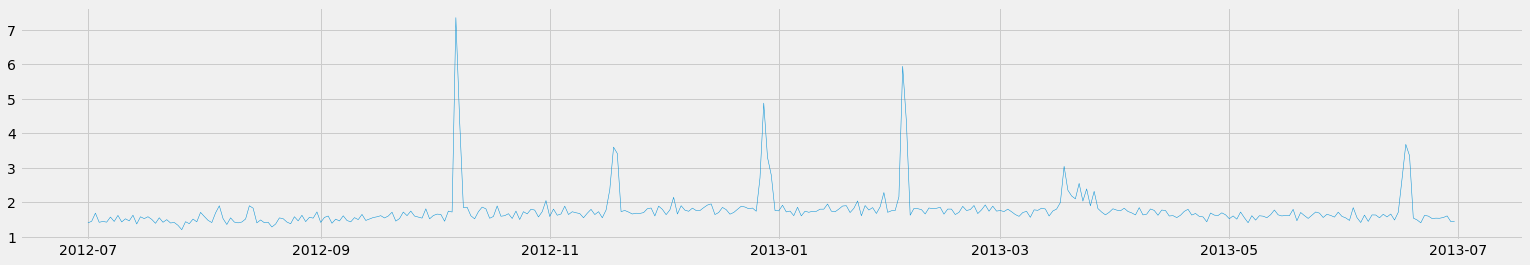

In [37]:
hhid = 'MAC000004'
hh_df = df.loc[df['item_id'] == hhid, ['timestamp', 'target_value']]
hh_df = hh_df.set_index('timestamp')

fig = plt.figure(figsize=(24,4))
plt.plot(hh_df, linewidth=0.5)
plt.show()